# 摘要

# 理论模型

炼焦煤包括焦煤、肥煤、1/3焦煤、瘦煤、气肥煤、气煤等几大类。中国炼焦煤各煤种储量不均匀，以气煤（包括1/3焦煤）最多，占炼焦煤探明储量的 45.73%，其次为焦煤，占 23.61%。

焦煤又称“主焦煤”，属于强粘结性、结焦性的炼焦煤煤种，是焦炭生产中不可或缺的基础原料配煤。通常在焦炭生产中，对焦煤的配入比例一般存在下限要求，一般比例大约占 30%-50%，每生产一吨焦炭大约需要消耗焦煤 1.33 吨。焦煤作为最具有代表性的炼焦煤，联接着煤、焦、钢三个产业，在产业链条上具
有重要地位。

能用于期货交割的焦煤必须是经过洗煤厂洗选后的精煤，并且利用镜质体反射率标准差指标来严格限定为单一煤种，同时利用小焦炉实验手段确保其具有足够的结焦性。

目前中国已成为世界上最大的炼焦煤生产国和消费国，华北及周边为炼焦精煤主产地。

![焦煤](.\images\焦煤.PNG)

## 价格影响因素

**宏观经济**

**产业政策**

产业政策的变化会直接影响煤炭生产企业的生产成本。

**库存因素**

库存反映供需平衡情况。

**需求因素**

焦炭是焦煤的下游产品，两者价格高度正相关。焦炭比焦煤更接近终端产品，对市场需求的反映更快，反映幅度更大。焦炭生产量代表市场对焦煤的需求。一般而言，需求变化领先于焦煤价格变化。

粗钢产量也反映市场对焦煤的需求。粗钢产量月同比增长变化趋势与焦煤价格走势总体一致，且领先于焦煤价格变化。

# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("D:\\HST\\QuantStudio")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

from WindPy import w
import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2()

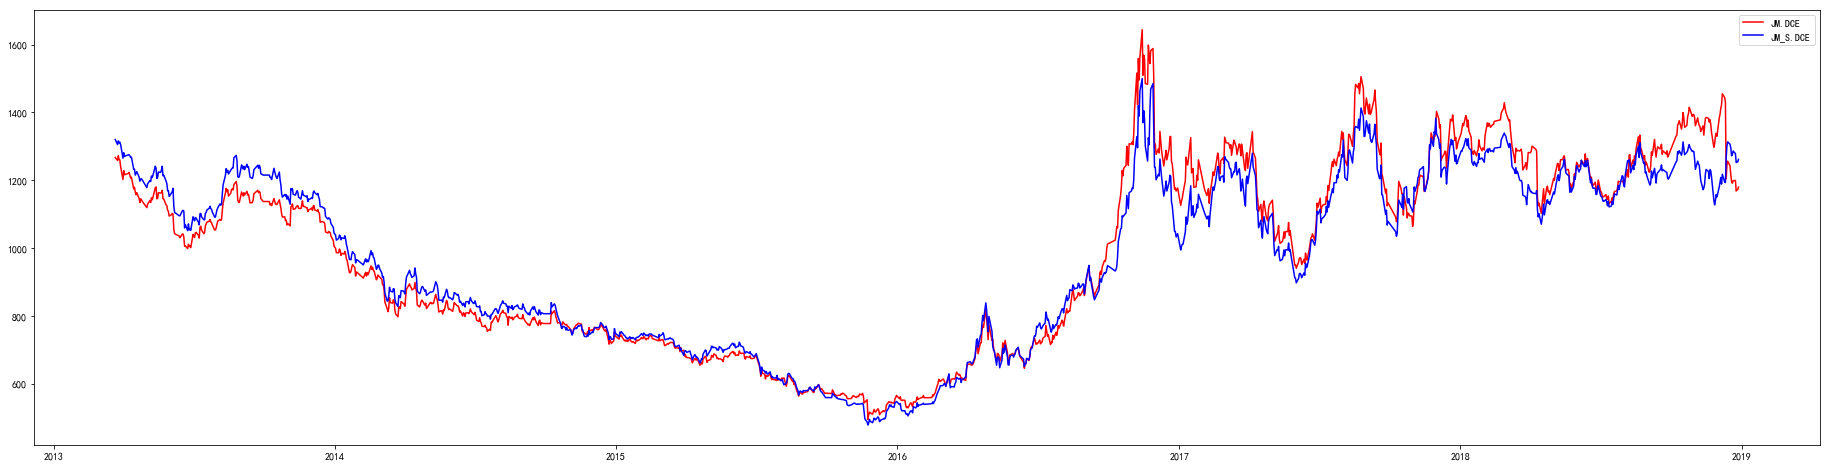

In [2]:
# 参数设置和数据准备
Exchange = "DCE"
MID, SID = "JM.DCE", "JM_S.DCE"# 主力和次主力合约
StartDT = dt.datetime(2013, 3, 22)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[MID, SID], dts=DTs).iloc[0,:,:]
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
CCPrice = FT.readData(factor_names=[PriceFactor], ids=[MID, SID], dts=DTs).iloc[0]
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
WDB.disconnect()
# 对连续合约的价格进行调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in CCPrice.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, CCPrice.columns]

Fig, Axes = plt.subplots(1, 1, figsize=(32, 8))
Axes.plot(CCPrice.index, CCPrice.values[:, 0], color='r', label=CCPrice.columns[0])
Axes.plot(CCPrice.index, CCPrice.values[:, 1], color='b', label=CCPrice.columns[1])
Axes.legend(loc='best');

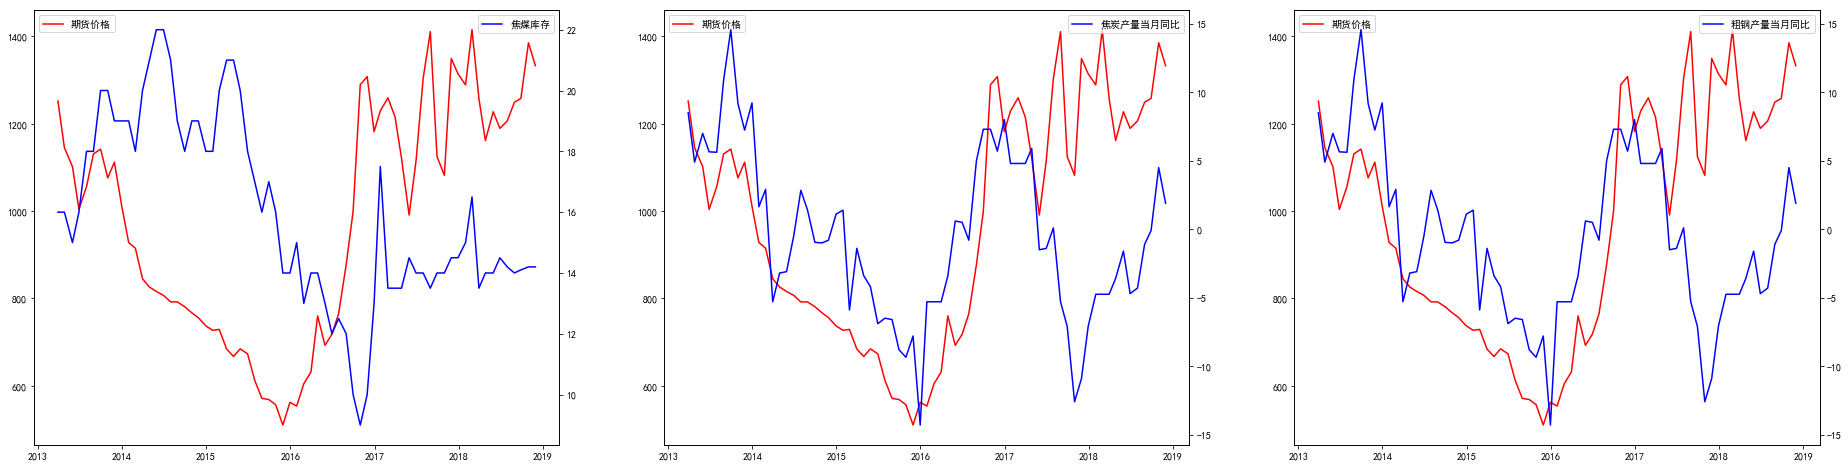

In [13]:
# 参数设置和数据准备
FutureID = "JM.DCE"# 设置目标期货 ID
StartDT = dt.datetime(2005, 1, 1)# 设置回测开始日期
EndDT = dt.datetime(2018, 11, 30)# 设置回测截止日期

WDB.connect()

# 获取主力合约的价格
FT = WDB.getTable("中国商品期货日行情")
DTs = FT.getDateTime(iid=FutureID, start_dt=StartDT, end_dt=EndDT)
FuturePrice = FT.readData(factor_names=["结算价(元)"], ids=[FutureID], dts=DTs).iloc[0, :, 0]

WDB.disconnect()

MonthDTs = QS.Tools.DateTime.getMonthLastDateTime(DTs)

# 焦煤库存
JMQC = w.edb("S5118223", StartDT.strftime("%Y-%m-%d"), EndDT.strftime("%Y-%m-%d"),"Fill=Previous")# 国内大中型钢厂炼焦煤平均库存可用天数
JMQC = pd.Series(JMQC.Data[0], index=[dt.datetime.combine(iDate, dt.time(0)) for iDate in JMQC.Times])
JMQC = JMQC.loc[JMQC.index.union(MonthDTs)].sort_index().fillna(method="ffill").loc[MonthDTs]

# 焦炭产量当月同比值
JTTB = w.edb("S0026998", StartDT.strftime("%Y-%m-%d"), EndDT.strftime("%Y-%m-%d"),"Fill=Previous")
JTTB = pd.Series(JTTB.Data[0], index=[dt.datetime.combine(iDate, dt.time(0)) for iDate in JTTB.Times])
JTTB = JTTB.loc[JTTB.index.union(MonthDTs)].sort_index().fillna(method="bfill").loc[MonthDTs]

# 粗钢产量当月同比值
CGTB = w.edb("S0026998", StartDT.strftime("%Y-%m-%d"), EndDT.strftime("%Y-%m-%d"),"Fill=Previous")
CGTB = pd.Series(CGTB.Data[0], index=[dt.datetime.combine(iDate, dt.time(0)) for iDate in CGTB.Times])
CGTB = CGTB.loc[CGTB.index.union(MonthDTs)].sort_index().fillna(method="bfill").loc[MonthDTs]

FutureMonthPrice = FuturePrice.loc[MonthDTs]

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].plot(FutureMonthPrice.index, FutureMonthPrice.values, color='r', label="期货价格")
RAxis = Axes[0].twinx()
RAxis.plot(JMQC.index, JMQC.values, color='b', label="焦煤库存")
Axes[0].legend(loc='upper left')
RAxis.legend(loc='upper right')
Axes[1].plot(FutureMonthPrice.index, FutureMonthPrice.values, color='r', label="期货价格")
RAxis = Axes[1].twinx()
RAxis.plot(JTTB.index, JTTB.values, color='b', label="焦炭产量当月同比")
Axes[1].legend(loc='upper left')
RAxis.legend(loc='upper right')
Axes[2].plot(FutureMonthPrice.index, FutureMonthPrice.values, color='r', label="期货价格")
RAxis = Axes[2].twinx()
RAxis.plot(CGTB.index, CGTB.values, color='b', label="粗钢产量当月同比")
Axes[2].legend(loc='upper left')
RAxis.legend(loc='upper right');

In [19]:
# -----------回归分析----------
# 焦煤价格 = const + lag(焦煤库存, 1) + lag(焦炭产量, 1) + lag(粗钢产量, 1)
xData = np.c_[np.r_[np.nan, JMQC.values[0:-1]], np.r_[np.nan, JTTB.values[0:-1]], np.r_[np.nan, CGTB.values[0:-1]]]
Result = sm.OLS(FutureMonthPrice.values, sm.add_constant(xData, prepend=True), missing='drop').fit()
Result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     13.67
Date:                Fri, 04 Jan 2019   Prob (F-statistic):           1.11e-05
Time:                        10:42:40   Log-Likelihood:                -463.94
No. Observations:                  68   AIC:                             933.9
Df Residuals:                      65   BIC:                             940.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1579.9437    147.800     10.690      0.000    1284.767    1875.120
x1           -37.6881      9.074     -4.153      0.000     -55.810     -19.566
x2             7.6215      2.304      3.308      0.002       3.020      12.223
x3             7.6215      2.304      3.308      0.002       3.020      12.223
==============================================================================
Omnibus:                        2.202   Durbin-Watson:                   0.272
Prob(Omnibus):                  0.333   Jarque-Bera (JB):                1.721
Skew:                           0.222   Prob(JB):                        0.423
Kurtosis:                       2.359   Cond. No.                     2.53e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.83e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# 附录

## 期货合约

![焦煤期货合约](.\images\焦煤期货合约.PNG)

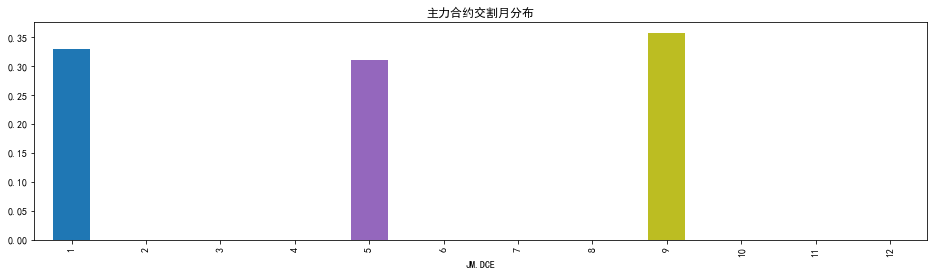

In [3]:
# 获取主力合约的月合约的交割月分布
import re
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
ExpiryMonthDistribution = ExpiryMonth.groupby(by=ExpiryMonth).count() / ExpiryMonth.shape[0]
ExpiryMonthDistribution = ExpiryMonthDistribution.loc[np.arange(1, 13)].fillna(0)
ExpiryMonthDistribution.plot(kind="bar", figsize=(16, 4), title="主力合约交割月分布");

焦煤期货的主力合约的交割月主要为 1, 5, 9 三个月。

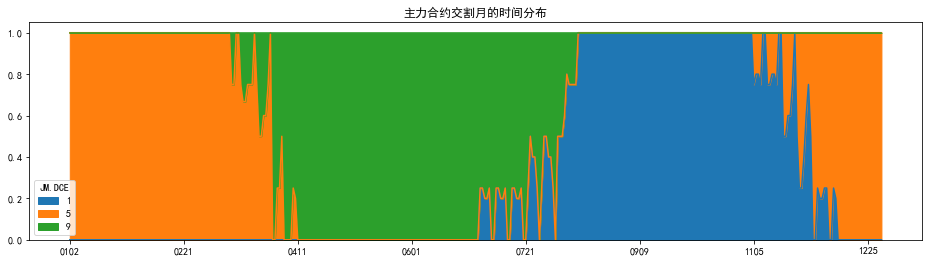

In [4]:
# 获取主力合约切换的时间分布
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
MonthDay = pd.Series([iDT.strftime("%m%d") for iDT in ExpiryMonth.index], index=ExpiryMonth.index)
ExpiryMonthDistributionPerYear = ExpiryMonth.groupby(by=[ExpiryMonth, MonthDay]).count().unstack()
ExpiryMonthDistributionPerYear = (ExpiryMonthDistributionPerYear / ExpiryMonth.groupby(by=MonthDay).count()).T
ExpiryMonthDistributionPerYear = ExpiryMonthDistributionPerYear.fillna(0)
Fig, Axes = plt.subplots(1, 1, figsize=(16, 4))
Axes = ExpiryMonthDistributionPerYear.plot(kind="area", ax=Axes, title="主力合约交割月的时间分布")
xTicks = Axes.get_xticks().astype(np.int)
xTickLabels = np.full(shape=xTicks.shape, fill_value="", dtype="O")
Mask = ((xTicks>=0) & (xTicks<ExpiryMonthDistributionPerYear.shape[0]))
xTickLabels[Mask] = ExpiryMonthDistributionPerYear.index.values[xTicks[Mask].tolist()]
Axes.set_xticklabels(xTickLabels);

焦煤期货的主力合约在每年的 3~4 月份从 5 月合约切换为 9 月合约，在 7~8 月份从 9 月合约切换为 1 月合约，在 11~12 月份从 1 月合约切换到 5 月合约。